In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import sys
sys.path.append(".\deep-learning-from-scratch")
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [8]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

In [9]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

In [10]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={"filter_num":30, "filter_size":5, "stride":1, "pad":0},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param["filter_num"]
        filter_size = conv_param["filter_size"]
        filter_stride = conv_param["stride"]
        filter_pad = conv_param["pad"]
        input_size = input_dim
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) ** 2)
        
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(filter_num, input_dim[0],
                                                              filter_size, filter_size)
        self.params["b1"] = np.zeros(filter_num)
        self.params["W2"] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params["b2"] = np.zeros(hidden_size)
        self.params["W3"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b3"] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers["Conv1"] = Convolution(self.params["W1"], self.params["b1"],
                                           conv_param["stride"], conv_param["pad"])
        self.layers["Relu1"] = Relu()
        self.layers["Pool1"] = Pooling(pool_h=2, pool_2=2, stride=2)
        self.layers["Affine1"] = Affine(self.params["W2"], self.params["b2"])
        self.layers["Relu2"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W3"], self.params["b3"])
        
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout = 1
        dout = self.lasy_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads["W1"] = self.layers["Conv1"].dW
        grads["b1"] = self.layers["Conv1"].db
        grads["W2"] = self.layers["Affine1"].dW
        grads["b2"] = self.layers["Affine1"].db
        grads["W3"] = self.layers["Affine2"].dW
        grads["b3"] = self.layers["Affine2"].db
        
        return grads

train loss:2.2997569369176047
=== epoch:1, train acc:0.147, test acc:0.169 ===
train loss:2.2962178160640985
train loss:2.29315614014403
train loss:2.284084065953304
train loss:2.2785411667119515
train loss:2.2646334922705025
train loss:2.253893936202644
train loss:2.243240776555138
train loss:2.2194956978828886
train loss:2.194803213532788
train loss:2.17109528538429
train loss:2.1521774136111915
train loss:2.131193288803014
train loss:2.0425248456934755
train loss:2.016206164175953
train loss:1.9385928997726567
train loss:1.8692067801117793
train loss:1.7700881550400343
train loss:1.6988319066962407
train loss:1.6105613327048849
train loss:1.5548369264106272
train loss:1.570659097901521
train loss:1.5343762662892877
train loss:1.416357556323223
train loss:1.1947987986821
train loss:1.2411774381812237
train loss:1.1406493771274944
train loss:1.1071079622803994
train loss:1.057412830563023
train loss:0.9631983406586865
train loss:1.0056003765198427
train loss:1.0148855091293583
train l

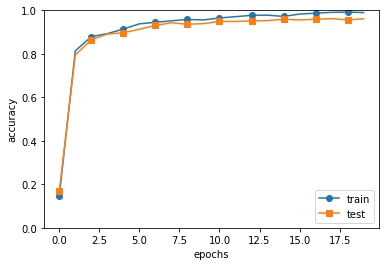

In [13]:
from dataset.mnist import load_mnist
from ch07.simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
